# **Setting up chroma vectorDB, OpenAI and cohere re-ranking model**



In [ ]:
!pip install chromadb
!pip install openai
!pip install cohere

https://www.trychroma.com/

In [ ]:
# @title ***Initialise VectorDB - Chroma***

import chromadb
chromadb_client = chromadb.Client()

In [ ]:
# chromadb_client.delete_collection(name="data_sources")

In [ ]:
# @title **Create Collection to store data sources**
chromadb_collection = chromadb_client.get_or_create_collection("data_sources")


In [ ]:
# @title ***Initialise OpenAi***
openai_key = "" # @param {type:"string"}
from openai import OpenAI
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=openai_key
)



Signup and get api key from https://dashboard.cohere.com/api-keys


In [ ]:
# @title ***Initialise Cohere***
cohere_key = "" # @param {type:"string"}
import cohere

# initialize the Cohere Client with an API Key
#get keys from
cohere_client = cohere.Client(cohere_key)

# **Source Data to Embedding to VectorDB**


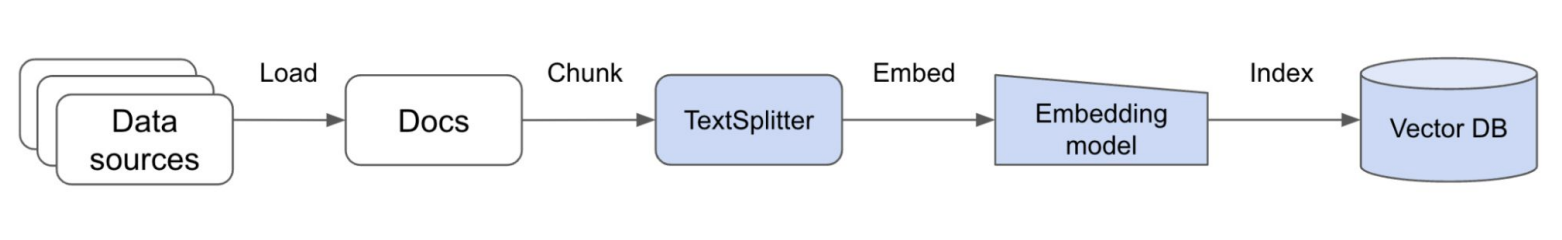

**Upload Naval's book in CSV format**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving naval(Building RAG based AI Apps).csv to naval(Building RAG based AI Apps).csv


In [ ]:
%ls


'naval(Building RAG based AI Apps).csv'   sample_data/


**TextSplitter/Chunking**

In [ ]:
def chunk_text(text, chunk_size=500, overlap=100):
    # Create chunks with overlapping data, ensuring it splits at the end and start of a word
    chunks = []
    i = 0
    while i < len(text):
        start_index = i
        end_index = i + chunk_size + overlap

        # Find the closest space before the chunk boundary (end)
        if end_index < len(text):
            while end_index > i and text[end_index] != ' ':
                end_index -= 1

        # Find the closest space before the chunk boundary (start)
        while start_index < len(text) and start_index < end_index and text[start_index] != ' ':
            start_index += 1

        chunks.append(text[start_index:end_index].strip())
        i = end_index - overlap

    return chunks

In [ ]:
import csv

def read_csv(file_path):
    data_array = []

    with open(file_path, newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)

        # Skip the header row if present
        next(csv_reader, None)

        for row in csv_reader:
            sno, chapter_title, chapter_url, chapter_content = row

            # Chunk the Chapter Content
            chunks = chunk_text(chapter_content)

            data_array.append({
                'sno': sno,
                'chapter_title': chapter_title,
                'chapter_url': chapter_url,
                'chunks': chunks
            })

    return data_array

In [ ]:
file_path = 'naval(Building RAG based AI Apps).csv'
result_array = read_csv(file_path)

In [ ]:
# Print the result array
for entry in result_array[12:14]:
  print(entry['sno'])
  for chunk in entry['chunks']:
    print("-"+chunk)



13
-encountered plenty of bad luck along the way. The first little fortune I made I instantly lost in the stock market. The second little fortune I made, or should have made, I basically got cheated out of by my business partners. It’s only the third time around that has been a charm. Even then, it has been a slow and steady struggle. I haven’t made money in my life in one giant payout. It has always been a whole bunch of small things piling up. It’s more about consistently creating wealth by creating businesses, creating opportunities, and creating investments. It hasn’t been a giant one-off
-businesses, creating opportunities, and creating investments. It hasn’t been a giant one-off thing. My personal wealth has not been generated by one big year. It just stacks up a little bit, a few chips at a time: more options, more businesses, more investments, more things I can do. Thanks to the internet, opportunities are massively abundant. In fact, I have too many ways to make money. I don’t

**Embed Chunks into VectorDB**

In [ ]:
for entry in result_array:
  for index, chunk in enumerate(entry['chunks']):
    chromadb_collection.add(ids=[f"{entry['sno']}_{index}"],
                            documents=[chunk],
                            metadatas=[{ **{'url': entry['chapter_url'],
                            'title':entry['chapter_title']}}])

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 69.5MiB/s]


# **Retrieval based on a Query**

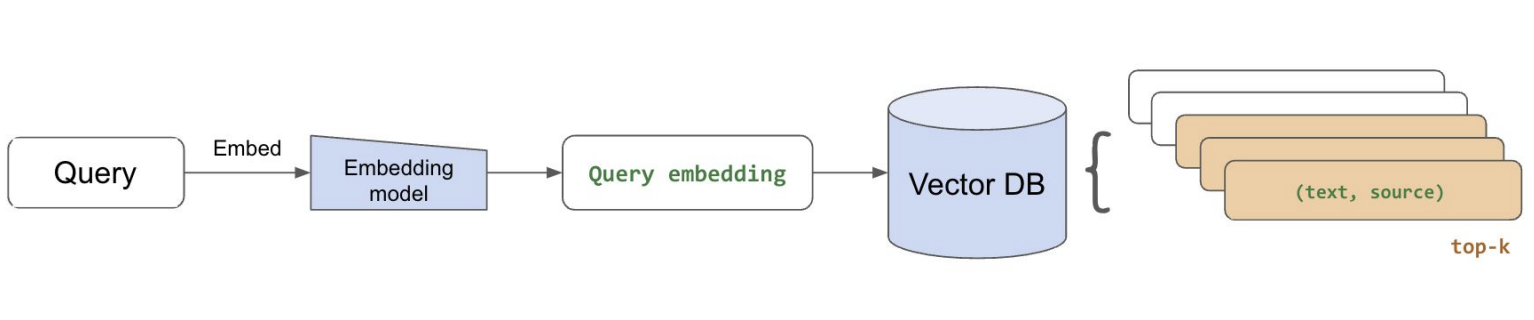

In [ ]:
query = "How to make money. give 5 points"

In [ ]:
def get_top_k_context(query, n_results):
  top_k_context = chromadb_collection.query(
    query_texts = [query],
    n_results = n_results
)
  converted_data = {}

  for i, doc_id in enumerate(top_k_context["ids"][0]):
      metadata = top_k_context["metadatas"][0][i]
      document = top_k_context["documents"][0][i]

      converted_data[doc_id] = {
          "chapter_name": metadata["title"],
          "url": metadata["url"],
          "snippet": document
      }
  top_k_context = converted_data
  return top_k_context


In [ ]:
top_k_context = get_top_k_context(query,5)
print(top_k_context)

{'11_5': {'chapter_name': 'Find a Position of Leverage', 'url': 'https://www.navalmanack.com/almanack-of-naval-ravikant/find-a-position-of-leverage', 'snippet': 'for how to make money, but the reality is, there’s no skill called “business.”\xa0[1] Think about what product or service society wants but does not yet know how to get. You want to become the person who delivers it and delivers it at scale. That is really the challenge of how to make money. Now, the problem is becoming good at whatever “it” is. It moves around from generation to generation, but a lot of it happens to be in technology. You are waiting for your moment when something emerges in the world, they need a skill set, and you’re uniquely qualified. You build your brand in the meantime on'}, '15_5': {'chapter_name': 'How to Get Lucky', 'url': 'https://www.navalmanack.com/almanack-of-naval-ravikant/how-to-get-lucky', 'snippet': 'starts fading from luck to destiny. To summarize the fourth type: build your character in a c

# **Response Generation**

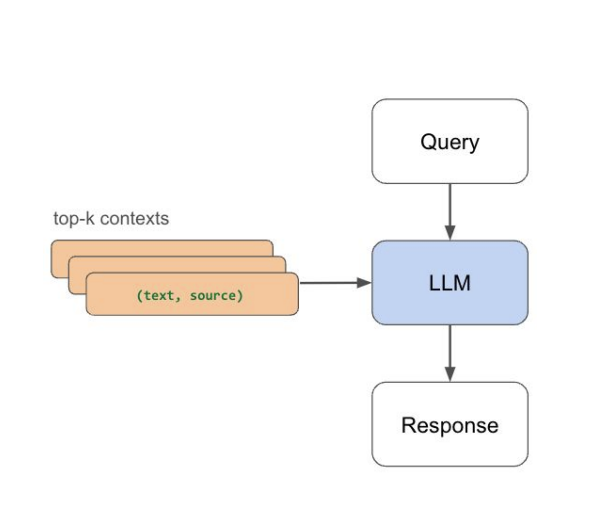

In [ ]:
def generate_response(query, top_k_context):
    prompt = f"Given is a query {query}. Answer the query from snippets from a book  {top_k_context}. also include reference like url, title etc. In your answer dont mention word snippets, just answer like you have read the book and providing the expert answer"
    messages = [
        {"role": "system", "content": "You are a helpful assistant who help other find and synthesise insights and able to answer user questions from the given book snippets."},
        {"role": "user", "content": prompt}
    ]
    response = openai_client.chat.completions.create(
        model="gpt-4-1106-preview",  #gpt-4-turbo
        messages=messages,
        max_tokens=1024,
        n=1,
        stop=None
    )
    return response.choices[0].message.content

In [ ]:
generate_response(query,top_k_context)

'To make money, consider the following five points, which are based on insights derived from the book "The Almanack of Naval Ravikant":\n\n1. **Find a Position of Leverage**: Focus on discovering what product or service society wants but doesn\'t yet have access to. You should strive to be the one who delivers this product or service and does so on a large scale. Often, opportunities for leverage can be found in technology, where your unique skill set might provide you with an advantage at the right moment. (Reference: "Find a Position of Leverage" - https://www.navalmanack.com/almanack-of-naval-ravikant/find-a-position-of-leverage)\n\n2. **Build a Good Reputation**: Cultivate a character of trust, reliability, and integrity. A strong reputation can lead to opportunities where others entrust you with deals because they believe in your ability to handle transactions in a trustworthy manner. Your character in this sense will ultimately shape your destiny and open doors to making money. (

# **Reranking**

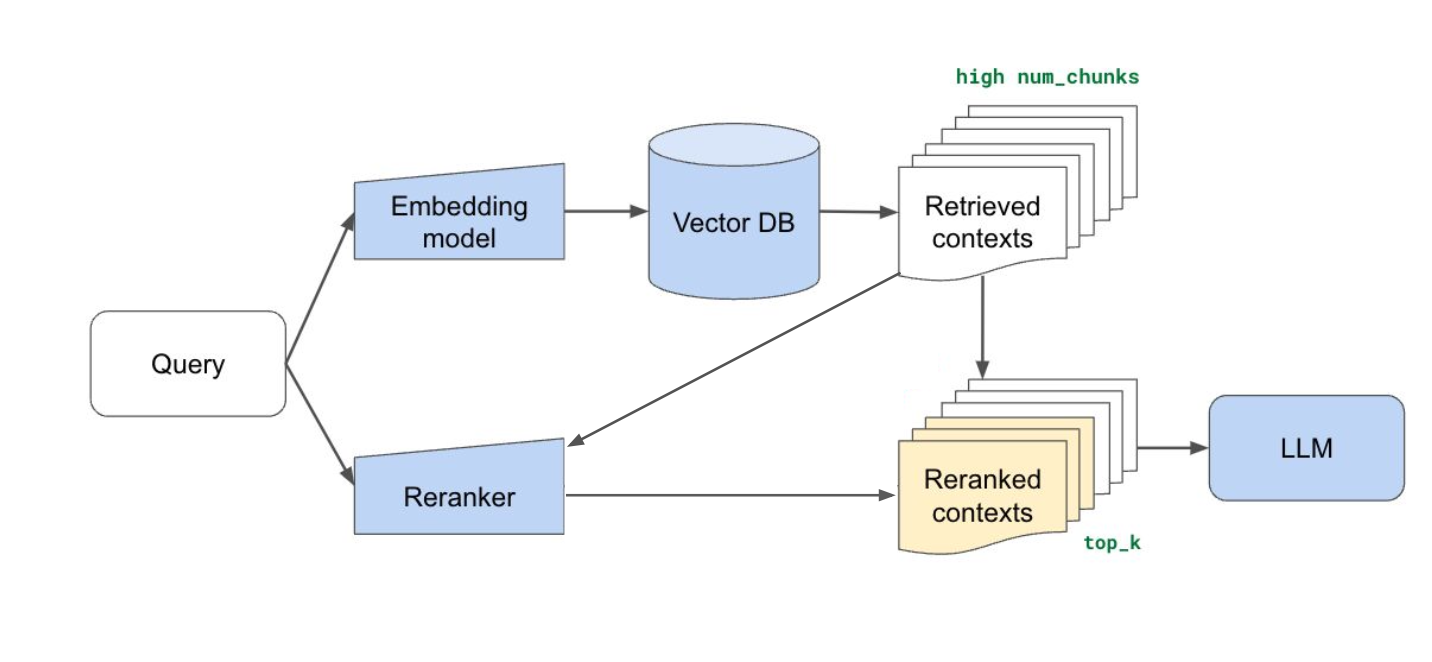

**Refer cohere Rerank API - https://docs.cohere.com/reference/rerank-1**

In [ ]:
def get_reranked_top_k_context(query, num_chunks):
  top_k_context = get_top_k_context(query, num_chunks)
  docs = [top_k_context[context_id]["snippet"] for context_id in top_k_context]

  response = cohere_client.rerank(
  model = 'rerank-english-v2.0',
  query = query,
  documents = docs,
  top_n = 5,
)
  result_dicts = []

  for result in response:
      result_dict = {
          'text': result.document['text'],
          'relevance_score': result.relevance_score,
          'index': result.index
      }
      result_dicts.append(result_dict)

  reranked_top_k_context = {}

  for i, result_dict in enumerate(result_dicts):
      # Use the index from result_dict to get the corresponding item in top_k_context
      index = result_dict['index']
      # Get the item in top_k_context based on sequence order
      if i < len(top_k_context):
          item_in_top_k = list(top_k_context.values())[index]
          key_in_top_k = list(top_k_context.keys())[index]


          # Append the item to mapped_data
          reranked_top_k_context[key_in_top_k] = item_in_top_k

  return reranked_top_k_context


In [ ]:
reranked_top_k_context = get_reranked_top_k_context(query, 10)
print (reranked_top_k_context)

{'7_10': {'chapter_name': 'Find and Build Specific Knowledge', 'url': 'https://www.navalmanack.com/almanack-of-naval-ravikant/find-and-build-specific-knowledge', 'snippet': 'to figure out. If you’re not 100 percent into it, somebody else who is 100 percent into it will outperform you. And they won’t just outperform you by a little bit—they’ll outperform you by a lot because now we’re operating the domain of ideas, compound interest really applies and leverage really applies.\xa0[78] The internet has massively broadened the possible space of careers. Most people haven’t figured this out yet. You can go on the internet, and you can find your audience. And you can build a business, and create a product, and build wealth, and make people happy just uniquely'}, '15_5': {'chapter_name': 'How to Get Lucky', 'url': 'https://www.navalmanack.com/almanack-of-naval-ravikant/how-to-get-lucky', 'snippet': 'starts fading from luck to destiny. To summarize the fourth type: build your character in a ce

In [ ]:
generate_response(query,reranked_top_k_context)

'To make money, considering insights from the book "The Almanack of Naval Ravikant," you can follow these five points:\n\n1. **Find and Build Specific Knowledge**: Put your full energy into an area that you’re passionate about because when you are 100 percent into it, you will likely outperform those who are not as committed. In the domain of ideas, compound interest and leverage are critical, and the internet has expanded the possible space of careers, allowing you to find your audience and build a business online. [Chapter: Find and Build Specific Knowledge](https://www.navalmanack.com/almanack-of-naval-ravikant/find-and-build-specific-knowledge)\n\n2. **Build a Strong Reputation**: Develop a reputation for trust, reliability, high integrity, and long-term thinking. By being a person others can trust for deals, you can become the go-to individual in your field, which can naturally lead to lucrative opportunities. [Chapter: How to Get Lucky](https://www.navalmanack.com/almanack-of-nav

# **Lexical Retrival**

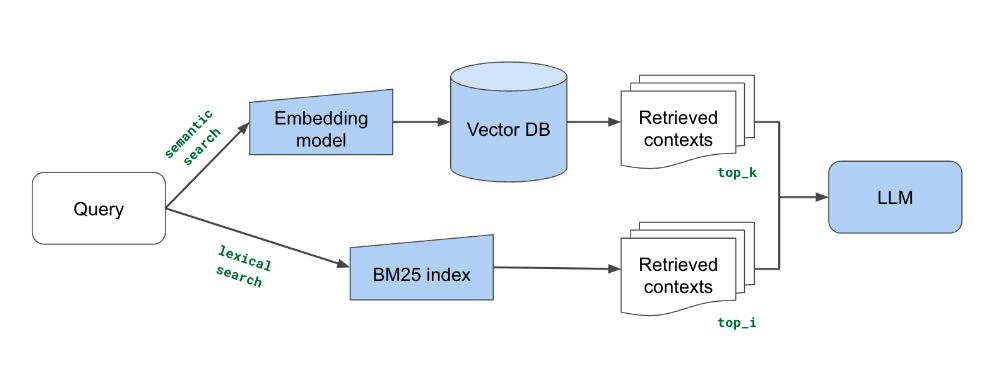

In [ ]:
!pip install rank-bm25

In [ ]:
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')


In [ ]:
# Function to tokenize text
def tokenize(text):
    return word_tokenize(text.lower())

In [ ]:
# Extract chunks from data
corpus = [chunk for entry in result_array for chunk in entry['chunks']]

# Tokenize chunks
tokenized_corpus = [tokenize(chunk) for chunk in corpus]
print(tokenized_corpus)

# Initialize BM25 model
bm25 = BM25Okapi(tokenized_corpus)


[['built', 'the', 'navalmanack', 'entirely', 'out', 'of', 'transcripts', ',', 'tweets', ',', 'and', 'talks', 'naval', 'has', 'shared', '.', 'every', 'attempt', 'is', 'made', 'to', 'present', 'naval', 'in', 'his', 'own', 'words', '.', 'however', ',', 'there', 'are', 'a', 'few', 'important', 'points', '.', '→', 'the', 'transcripts', 'have', 'been', 'edited', 'for', 'clarity', 'and', 'brevity', '(', 'multiple', 'times', ')', '.', '→', 'not', 'all', 'sources', 'are', 'primary', '(', 'some', 'excerpts', 'are', 'from', 'other', 'writers', 'quoting', 'naval', ')', '.', '→', 'i', 'can', '’', 't', 'be', '100', 'percent', 'certain', 'of', 'every', 'source', '’', 's', 'authenticity', '.', '→', 'concepts', 'and', 'interpretations', 'change', 'over', 'time', ',', 'medium', ',', 'and', 'context', '.', '→', 'please', 'verify', 'phrasing', 'with', 'a', 'primary', 'source', 'before', 'citing', 'naval', 'from', 'this', 'text', '.', '→', 'please', 'interpret'], ['verify', 'phrasing', 'with', 'a', 'primar

In [ ]:
query = "find opportunities to make money in the island and start again"

In [ ]:
 # Tokenize query
tokenized_query = tokenize(query)

# Get BM25 scores
scores = bm25.get_scores(tokenized_query)

# Combine scores with metadata
results = []
for entry, score in zip(result_array, scores):
    for chunk in entry['chunks']:
        results.append({
            'sno': entry['sno'],
            'chapter_title': entry['chapter_title'],
            'chapter_url': entry['chapter_url'],
            'chunk': chunk,
            'score': score
        })

# Sort the results based on scores
sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)

# Print top results
for result in sorted_results[:10]:  # Adjust the number of top results to display
    print(result)

{'sno': '29', 'chapter_title': 'Envy Is the Enemy of Happiness', 'chapter_url': 'https://www.navalmanack.com/almanack-of-naval-ravikant/envy-is-the-enemy-of-happiness', 'chunk': 'don’t think life is that hard. I think we make it hard. One of the things I’m trying to get rid of is the word “should.” Whenever the word “should” creeps up in your mind, it’s guilt or social programming. Doing something because you “should” basically means you don’t actually want to do it. It’s just making you miserable, so I’m trying to eliminate as many “shoulds” from my life as possible.\xa0[1] The enemy of peace of mind is expectations drilled into you by society and other people. Socially, we’re told, “Go work out. Go look good.” That’s a multiplayer competitive game. Other people can', 'score': 12.366994210848889}
{'sno': '29', 'chapter_title': 'Envy Is the Enemy of Happiness', 'chapter_url': 'https://www.navalmanack.com/almanack-of-naval-ravikant/envy-is-the-enemy-of-happiness', 'chunk': 'we’re told, 